In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
#KERAS_MODEL = "model.h5"
#WORD2VEC_MODEL = "model.w2v"
#TOKENIZER_MODEL = "tokenizer.pkl"
#ENCODER_MODEL = "encoder.pkl"

In [280]:
df = pd.read_csv('input/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df = df.sample(n=10000)

In [282]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [283]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

ValueError: invalid literal for int() with base 10: 'NEGATIVE'

Text(0.5, 1.0, 'Dataset labels distribuition')

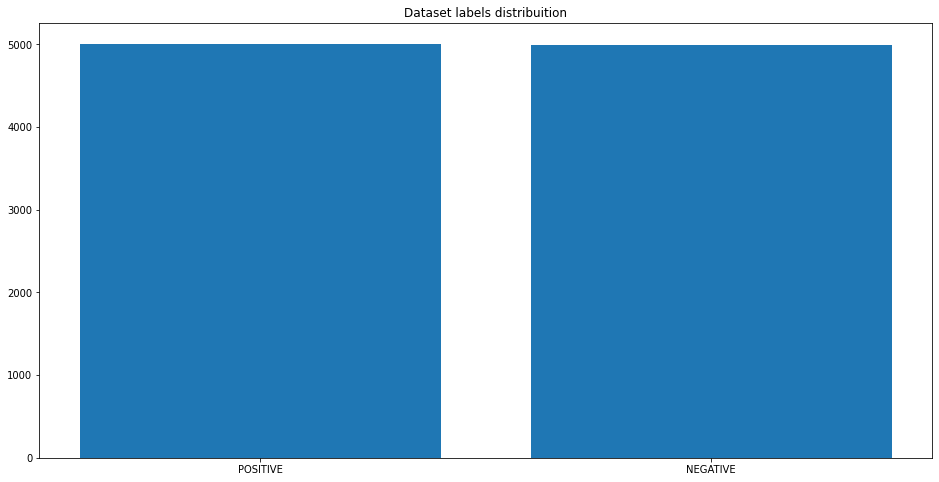

In [6]:
from collections import Counter
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [284]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [285]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [286]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [287]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [288]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 8000
TEST size: 2000


In [12]:
df_train.head()

,target,ids,date,flag,user,text
1518104,POSITIVE,2175921709,Mon Jun 15 02:23:19 PDT 2009,NO_QUERY,detoxcute,@parlotones 'Stars Fall Down' is brill - a kee...
1370453,POSITIVE,2051014809,Fri Jun 05 19:42:23 PDT 2009,NO_QUERY,omgitismanda,"@Missy_E: haha you should! nothing really, im..."
1169541,POSITIVE,1980274971,Sun May 31 06:15:26 PDT 2009,NO_QUERY,agiftedmind,@Saffiter :3 hehehe. Sounds like fun.
821791,POSITIVE,1554166695,Sat Apr 18 16:15:06 PDT 2009,NO_QUERY,princessferg,"@lindZhenson Welcome Linds to twitter, umm you..."
174314,NEGATIVE,1964456643,Fri May 29 14:15:53 PDT 2009,NO_QUERY,claudinekay,@Japes_76 haha. weird?!? no sunshine for us


In [13]:
# A) Removing Twitter Handles (@user)

In [14]:
combi = df_train.append(df_test, ignore_index=True)

In [15]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [16]:
# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*")

In [17]:
# Removing punctuations, numbers and special characters
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [18]:
# Removing short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [19]:
combi.head()

,target,ids,date,flag,user,text,tidy_tweet
0,POSITIVE,2175921709,Mon Jun 15 02:23:19 PDT 2009,NO_QUERY,detoxcute,@parlotones 'Stars Fall Down' is brill - a kee...,Stars Fall Down brill keeper
1,POSITIVE,2051014809,Fri Jun 05 19:42:23 PDT 2009,NO_QUERY,omgitismanda,"@Missy_E: haha you should! nothing really, im...",haha should nothing really with bleeker Were h...
2,POSITIVE,1980274971,Sun May 31 06:15:26 PDT 2009,NO_QUERY,agiftedmind,@Saffiter :3 hehehe. Sounds like fun.,hehehe Sounds like
3,POSITIVE,1554166695,Sat Apr 18 16:15:06 PDT 2009,NO_QUERY,princessferg,"@lindZhenson Welcome Linds to twitter, umm you...",Welcome Linds twitter love promise
4,NEGATIVE,1964456643,Fri May 29 14:15:53 PDT 2009,NO_QUERY,claudinekay,@Japes_76 haha. weird?!? no sunshine for us,haha weird sunshine


In [20]:
# Tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                   [Stars, Fall, Down, brill, keeper]
1    [haha, should, nothing, really, with, bleeker,...
2                               [hehehe, Sounds, like]
3             [Welcome, Linds, twitter, love, promise]
4                              [haha, weird, sunshine]
Name: tidy_tweet, dtype: object

In [21]:
# Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                    [star, fall, down, brill, keeper]
1    [haha, should, noth, realli, with, bleeker, we...
2                                 [heheh, sound, like]
3                [welcom, lind, twitter, love, promis]
4                               [haha, weird, sunshin]
Name: tidy_tweet, dtype: object

In [22]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

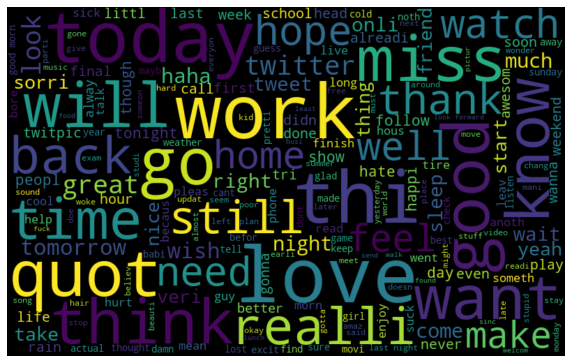

In [23]:
# WordCloud
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

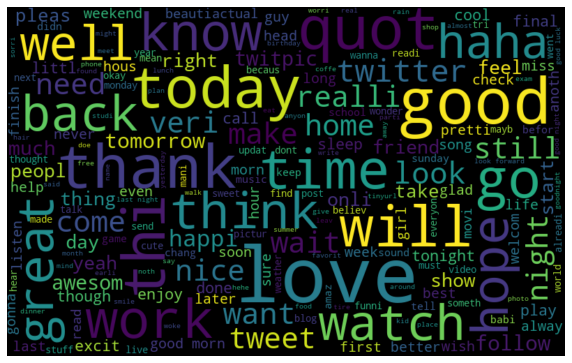

In [24]:
# POSITIVE words
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['target'] == 'POSITIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

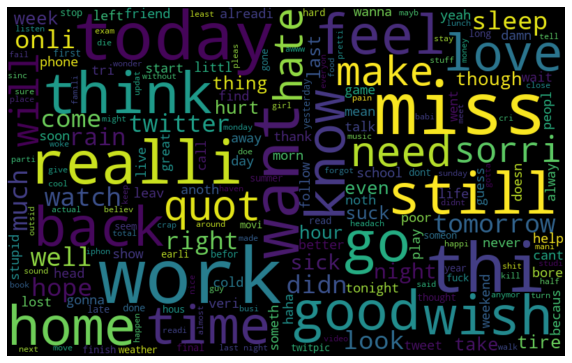

In [25]:
# NEGATIVE words
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['target'] == 'NEGATIVE']])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
# Hashtags on tweets
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [27]:
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['target'] == 'POSITIVE'])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['target'] == 'NEGATIVE'])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

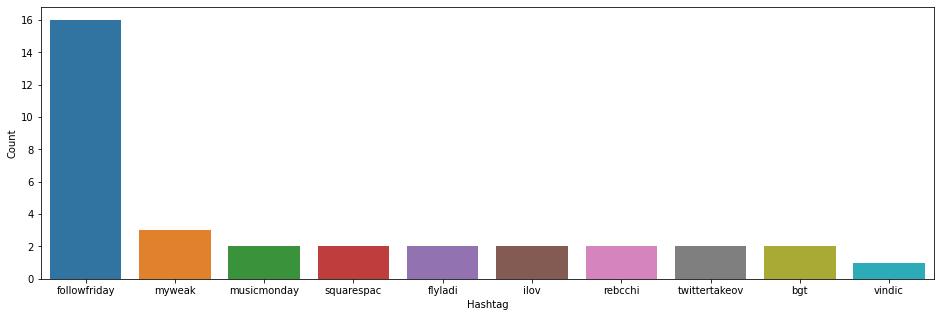

In [29]:
#POSITIVE Tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

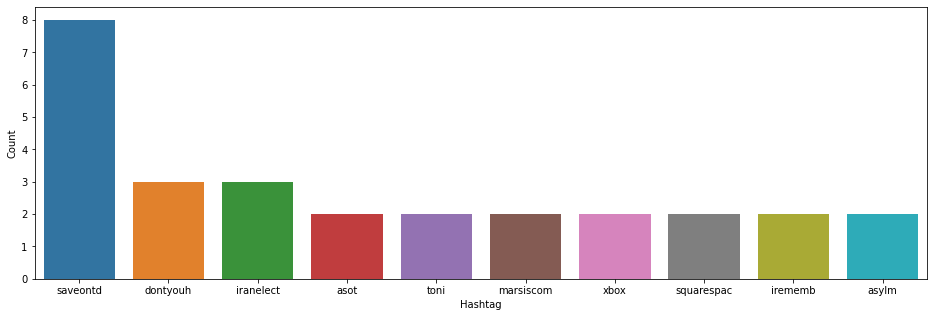

In [30]:
# NEGATIVE Tweets
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# Model building: Sentiment Analysis


In [246]:
tfidfstops=stopwords.words('english')

vectorizer = TfidfVectorizer(max_features=5000, stop_words= tfidfstops, tokenizer=process_tweets)
print(vectorizer)
tfidf_matrix = vectorizer.fit_transform(df['text'])
display(tfidf_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),columns= vectorizer.get_feature_names())
tfidf_df.head()

TfidfVectorizer(max_features=5000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function process_tweets at 0x139673ca0>)


/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<10000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 56535 stored elements in Compressed Sparse Row format>

,aaa,aaah,aaargh,aah,aaron,abba,able,abnormal,absolutely,absolutley,...,zappos,zealand,zenjar,zero,zoe,zoesparty,zoey,zone,zoo,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
#Vectorizar,polarizar y tokenizar palabras
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [248]:
def process_tweets(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop wordsGuardo
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    # Fit and transform the vectorizer
    return tokenized

In [249]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fernandodelgadoteran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [250]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer=process_tweets).fit(df['text'])
# Numero de palabras totales recogidas
print(len(bow_transformer.vocabulary_))

13054


In [251]:
# example of vectorized text
sample_tweet = df['text'].iloc[0]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

fuckya im fishing


  (0, 4138)	1
  (0, 4435)	1




In [252]:
messages_bow = bow_transformer.transform(df['text'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (10000, 13054)
Amount of Non-Zero occurences:  64589


In [253]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 4435)	0.7223259768885097
  (0, 4138)	0.6915527334282324


In [254]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['hate']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['happy']])

5.406419322243259
5.22683374526818


In [255]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(10000, 13054)


In [290]:
df["procesado"]= df["text"].str.lower().apply(process_tweets)

display(df[["procesado"]].head(15))

,procesado
340951,"[fell, asleep, around, last, night, woke, arou..."
1108830,"[going, town, late, get, prom, shoes, things, ..."
1147866,"[happy, day]"
52810,"[tummy, hurts, stupid, stress]"
392457,"[event, seen]"
1478539,"[excellent, good, indeed, posting]"
1276946,"[sigh, would, give, beach, somewhere]"
1533245,"[check, new, twitter, background, portfolio, s..."
933905,"[interesting, touch, type, properly, see, woul..."
772356,"[leave, cell, find]"


In [291]:
df.head()

,target,ids,date,flag,user,text,procesado
340951,NEGATIVE,2014943573,Wed Jun 03 03:11:56 PDT 2009,NO_QUERY,bexodus,@MissScion Fell asleep around 9p last night wo...,"[fell, asleep, around, last, night, woke, arou..."
1108830,POSITIVE,1971796339,Sat May 30 07:55:06 PDT 2009,NO_QUERY,sazmataz_x,@katie_andhearts going in town later to get my...,"[going, town, late, get, prom, shoes, things, ..."
1147866,POSITIVE,1978132662,Sat May 30 22:31:29 PDT 2009,NO_QUERY,Deasoy,happy day,"[happy, day]"
52810,NEGATIVE,1679901725,Sat May 02 10:26:43 PDT 2009,NO_QUERY,SashaPanda,Tummy Hurts Stupid Stress,"[tummy, hurts, stupid, stress]"
392457,NEGATIVE,2055154954,Sat Jun 06 08:48:06 PDT 2009,NO_QUERY,LianeGentrySkye,@jodywallace Are you at the LF event? I have...,"[event, seen]"


In [292]:
from sklearn.metrics.pairwise import cosine_similarity as cos
dist=1-cos(tfidf_matrix)

dist.shape
#leer que carajo es esto

(10000, 10000)

In [293]:
# Crear un nuevo DataFrame llamado frequencies
frequencies = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['total_frequency'])

# Ordenarlo por frecuencia
frequencies.sort_values(by='total_frequency',ascending=False, inplace=True)
# Display las 20 palabras + frecuentes
display(frequencies.head(20))

,total_frequency
good,186.388538
day,127.002680
like,123.156140
today,121.576487
work,119.868066
got,115.131796
love,114.636736
get,113.409249
lol,107.359506
know,106.996887


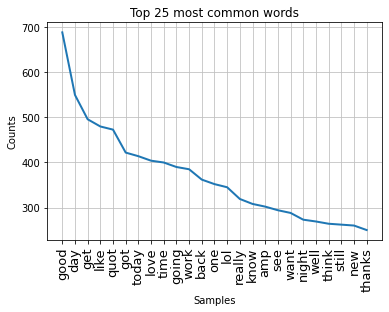

Text(0.5, 1.0, 'log-log plot of words frequency')

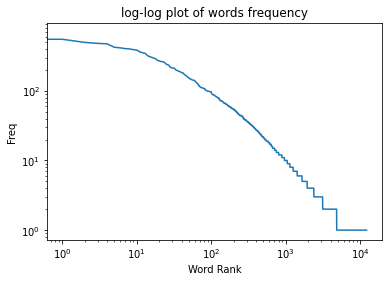

In [294]:
all_words = []
for line in df['procesado']:
    words = line
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

# plot word frequency distribution of first few words
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [295]:
df.to_csv("./output/FilteredDataSet.csv", index=False)

# Análisis

In [296]:
df = pd.read_csv('output/FilteredDataSet.csv')

In [297]:
df["Polaridad"] = df["procesado"].apply(lambda word: TextBlob(word).sentiment.polarity)
df["Subjetividad"] = df["procesado"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display Polaridad y al Subjetividad
display(df[["Polaridad","Subjetividad"]].head(10))

,Polaridad,Subjetividad
0,-0.016667,0.488889
1,0.250000,0.650000
2,0.800000,1.000000
3,-0.800000,1.000000
4,0.000000,0.000000
5,0.850000,0.800000
6,0.000000,0.000000
7,0.136364,0.454545
8,0.233333,0.400000
9,0.000000,0.000000


In [298]:
df.head()

,target,ids,date,flag,user,text,procesado,Polaridad,Subjetividad
0,NEGATIVE,2014943573,Wed Jun 03 03:11:56 PDT 2009,NO_QUERY,bexodus,@MissScion Fell asleep around 9p last night wo...,"['fell', 'asleep', 'around', 'last', 'night', ...",-0.016667,0.488889
1,POSITIVE,1971796339,Sat May 30 07:55:06 PDT 2009,NO_QUERY,sazmataz_x,@katie_andhearts going in town later to get my...,"['going', 'town', 'late', 'get', 'prom', 'shoe...",0.250000,0.650000
2,POSITIVE,1978132662,Sat May 30 22:31:29 PDT 2009,NO_QUERY,Deasoy,happy day,"['happy', 'day']",0.800000,1.000000
3,NEGATIVE,1679901725,Sat May 02 10:26:43 PDT 2009,NO_QUERY,SashaPanda,Tummy Hurts Stupid Stress,"['tummy', 'hurts', 'stupid', 'stress']",-0.800000,1.000000
4,NEGATIVE,2055154954,Sat Jun 06 08:48:06 PDT 2009,NO_QUERY,LianeGentrySkye,@jodywallace Are you at the LF event? I have...,"['event', 'seen']",0.000000,0.000000


In [303]:
def analizar_polaridad(polaridad):
    if polaridad > 0:
        return "Positiva"
    if polaridad == 0:
        return "Neutral"
    if polaridad < 0:
        return "Negativa"

df["target"] = df["Polaridad"].apply(analizar_polaridad)

# Display analisis de polaridad y subjetividad diferenciado en tres niveles: positivo, negativo y neutro
display(df[["target"]].head(10))

,target
0,Negativa
1,Positiva
2,Positiva
3,Negativa
4,Neutral
5,Positiva
6,Neutral
7,Positiva
8,Positiva
9,Neutral


In [304]:
# Visualización

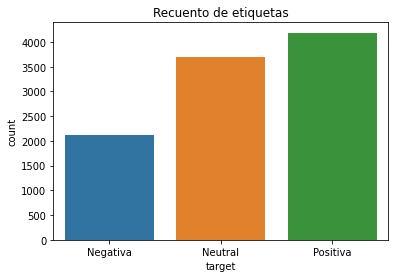

In [305]:
df["target"] = df["target"].astype("category")

# Visualizar el recuento total de labels segmentado por los tipos de positividad 
sns.countplot(df["target"])
plt.title("Recuento de etiquetas")
#plt.savefig('./imagenes/recuento_de_etiquetas.png')
plt.show()

In [314]:
df["palabras"] = df["text"].str.split().str.len()

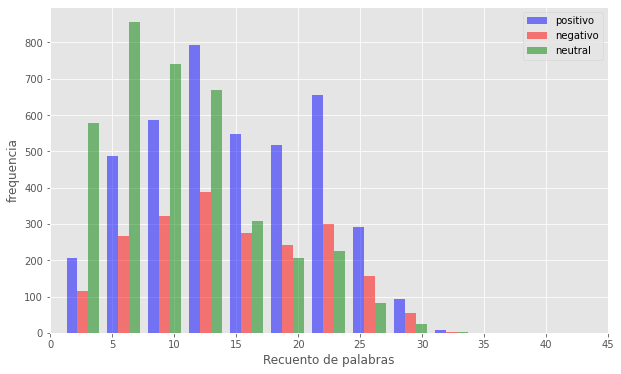

In [317]:
#Comparativa de tweets positivos vs negativos
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

x = df['palabras'][df.Polaridad > 0]
y = df['palabras'][df.Polaridad < 0]
z = df['palabras'][df.Polaridad == 0]
plt.xlim(0,45)
plt.xlabel('Recuento de palabras')
plt.ylabel('frequencia')
g = plt.hist([x, y,z], color=['b','r','green'], alpha=0.5, label=['positivo','negativo', 'neutral'])
plt.legend(loc='upper right');


In [320]:
df.to_csv("output/final_tweets.csv", index=False)